# Modelo 1 - Random Forest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from itertools import product

In [2]:
df = pd.read_csv('../data/handled/dataset.csv')
df['ventana_30min'] = pd.to_datetime(df['ventana_30min'])

df['dia_semana'] = df['ventana_30min'].dt.dayofweek
df['hora'] = df['ventana_30min'].dt.hour
df['minuto'] = df['ventana_30min'].dt.minute

features = ['dia_semana', 'hora', 'minuto', 'id_estacion', 'partidas', 'partidas_lag_1', 'partidas_lag_2', 
            'partidas_lag_3','latitud', 'longitud', 'nivel_horario', 'es_finde', 'tipo_estacion',
       'distancia_central_1', 'distancia_central_2', 'distancia_central_3',
       'distancia_central_4', 'distancia_central_5']

X = df[features]
y = df['bicis_arriban']

In [3]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

print(f"Train set size: {y_train.shape[0]}")
print(f"Validation set size: {y_val.shape[0]}")
print(f"Test set size: {y_test.shape[0]}")

Train set size: 5341270
Validation set size: 1335318
Test set size: 1669148
Train set size: 5341270
Validation set size: 1335318
Test set size: 1669148


In [4]:
orden = {'bajo': 0, 'medio': 1, 'alto': 2}
X_train['nivel_horario'] = X_train['nivel_horario'].map(orden)
X_val['nivel_horario'] = X_val['nivel_horario'].map(orden)

In [5]:
mapas_ordinales = {
    'tipo_estacion': {
        'fantasma': 0,
        'moderada': 1,
        'central': 2
    }
}

X_train['tipo_estacion'] = X_train['tipo_estacion'].map(mapas_ordinales['tipo_estacion'])
X_val['tipo_estacion'] = X_val['tipo_estacion'].map(mapas_ordinales['tipo_estacion'])


In [6]:
# Entrenar modelo (sin escalar)
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=42)
rf.fit(X_train, y_train)

# Predecir
y_pred_rf = rf.predict(X_val)

# Convertir a Series con mismo índice que y_val
y_pred_rf_series = pd.Series(y_pred_rf, index=y_val.index)

# Redondear (opcional)
y_pred_rf_rounded = y_pred_rf_series.round().astype(int)


In [7]:
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf_rounded))
mae_rf = mean_absolute_error(y_val, y_pred_rf_rounded)
r2_rf = r2_score(y_val, y_pred_rf_rounded)

print(f"Random Forest - RMSE: {rmse_rf:.2f}")
print(f"Random Forest - MAE: {mae_rf:.2f}")
print(f"Random Forest - R²: {r2_rf:.2f}")

Random Forest - RMSE: 0.88
Random Forest - MAE: 0.42
Random Forest - R²: 0.32


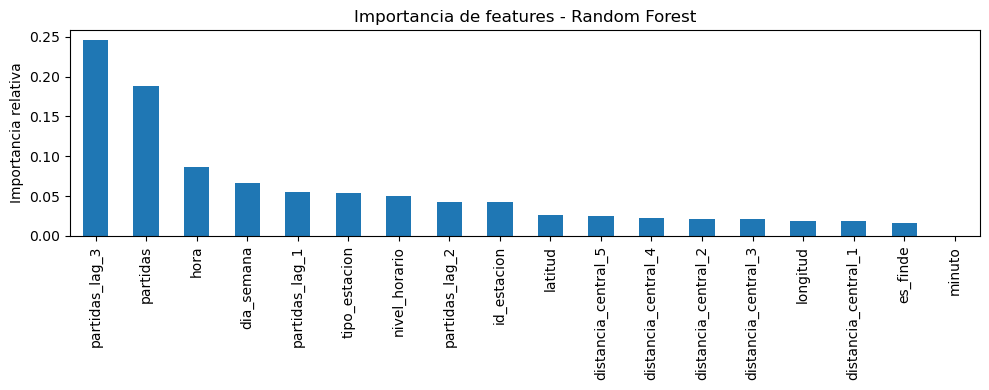

In [8]:
importancia = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,4))
importancia.plot(kind='bar')
plt.title("Importancia de features - Random Forest")
plt.ylabel("Importancia relativa")
plt.tight_layout()
plt.show()

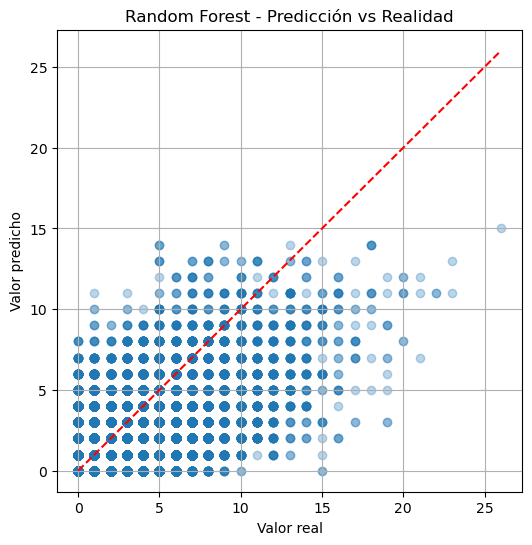

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_rf_rounded, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.title('Random Forest - Predicción vs Realidad')
plt.grid(True)
plt.show()

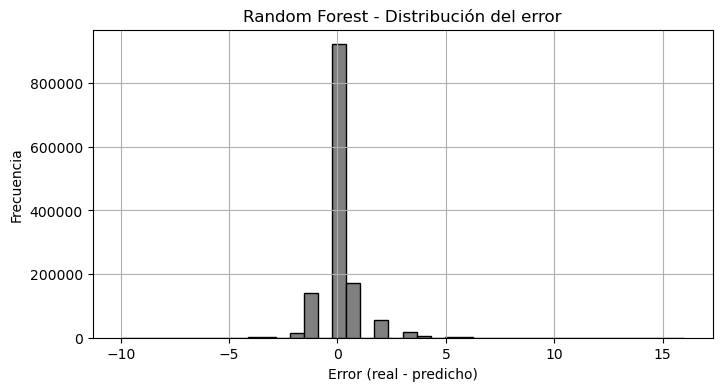

In [10]:
errores_rf = y_val - y_pred_rf_rounded

plt.figure(figsize=(8,4))
plt.hist(errores_rf, bins=40, color='gray', edgecolor='black')
plt.xlabel("Error (real - predicho)")
plt.ylabel("Frecuencia")
plt.title("Random Forest - Distribución del error")
plt.grid(True)
plt.show()


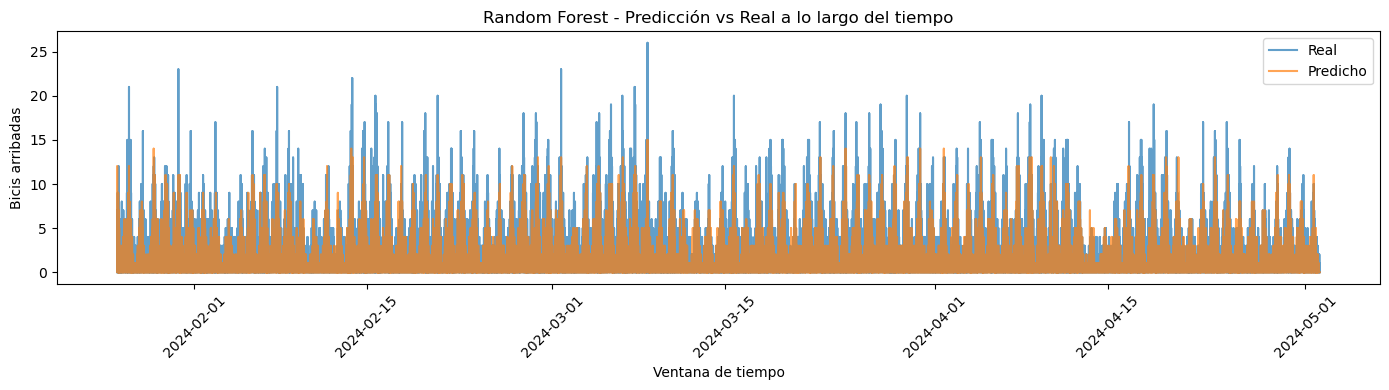

In [11]:
plt.figure(figsize=(14,4))
plt.plot(df.loc[y_val.index, 'ventana_30min'], y_val, label='Real', alpha=0.7)
plt.plot(df.loc[y_val.index, 'ventana_30min'], y_pred_rf_rounded, label='Predicho', alpha=0.7)
plt.xlabel("Ventana de tiempo")
plt.ylabel("Bicis arribadas")
plt.title("Random Forest - Predicción vs Real a lo largo del tiempo")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


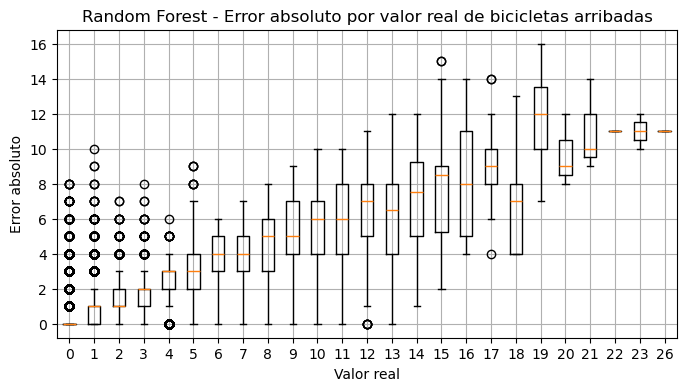

In [12]:
df_eval_rf = pd.DataFrame({
    'real': y_val,
    'pred': y_pred_rf_rounded
})
df_eval_rf['error'] = df_eval_rf['real'] - df_eval_rf['pred']
df_eval_rf['abs_error'] = df_eval_rf['error'].abs()

plt.figure(figsize=(8,4))
plt.boxplot(
    [df_eval_rf[df_eval_rf['real'] == v]['abs_error'] for v in sorted(df_eval_rf['real'].unique())],
    labels=sorted(df_eval_rf['real'].unique())
)
plt.title("Random Forest - Error absoluto por valor real de bicicletas arribadas")
plt.xlabel("Valor real")
plt.ylabel("Error absoluto")
plt.grid(True)
plt.show()


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from itertools import product
import numpy as np
import pandas as pd
import json

In [97]:
# Definí tu grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# Generar todas las combinaciones posibles
param_combos = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['max_features'],
    param_grid['bootstrap']
))

resultados = []

# Loop manual sobre cada combinación
for n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, bootstrap in param_combos:
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    resultado = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    resultados.append(resultado)

    with open("resultados_grid.json", "a") as f:
        json.dump(resultado, f)
        f.write("\n")


# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar las 5 mejores combinaciones según R²
top5 = df_resultados.sort_values(by='R2', ascending=False).head(5)
print(top5)


   n_estimators  max_depth  min_samples_split  min_samples_leaf max_features  \
6           200         20                  5                 2         sqrt   
2           100         20                  5                 2         sqrt   
7           200         20                  5                 2         sqrt   
3           100         20                  5                 2         sqrt   
4           200         10                  5                 2         sqrt   

       RMSE       MAE        R2  
6  0.830207  0.467497  0.396303  
2  0.830669  0.467702  0.395630  
7  0.831845  0.468049  0.393918  
3  0.832145  0.468163  0.393480  
4  0.849970  0.485965  0.367219  


In [17]:
# Entrenar modelo (sin escalar)
rf_2 = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, min_samples_leaf=2, max_features='sqrt', min_samples_split=5)
rf_2.fit(X_train, y_train)

# Predecir
y_pred_rf_2 = rf_2.predict(X_val)

# Convertir a Series con mismo índice que y_val
y_pred_rf_series_2 = pd.Series(y_pred_rf_2, index=y_val.index)

# Redondear (opcional)
y_pred_rf_rounded_2 = y_pred_rf_series_2.round().astype(int)


In [20]:
rmse_rf_2 = np.sqrt(mean_squared_error(y_val, y_pred_rf_rounded_2))
mae_rf_2 = mean_absolute_error(y_val, y_pred_rf_rounded_2)
r2_rf_2 = r2_score(y_val, y_pred_rf_rounded_2)

print(f"Random Forest - RMSE: {rmse_rf_2:.2f}")
print(f"Random Forest - MAE: {mae_rf_2:.2f}")
print(f"Random Forest - R²: {r2_rf_2:.2f}")

Random Forest - RMSE: 0.87
Random Forest - MAE: 0.42
Random Forest - R²: 0.34
